In [13]:
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import shapely.geometry as sg
import pandas as pd
import scipy.spatial as ss

import os
import json
import numpy as np
import squidpy as sq

import sklearn
import statannotations

import spatial_rgc.utils.model_constants as constants
%matplotlib auto
#FOR NIKHIL: CHANGE THIS

DATA_DIR= os.path.join(constants.BASE_DIR,"data")
MOSAIC_DATA_DIR = os.path.join(DATA_DIR,"mosaic_data")
FIGURE_DIR = os.path.join(constants.BASE_DIR,"figures","Figure_4")
#REGION_DIR = os.path.join("..","..","regions") #Ignore for now; only for VDRI
WIDE_CONTEXT = {'font.size':8,'figure.dpi':300}

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

NULL_COLOR, OBSERVED_COLOR = 'lightgrey', 'royalblue'
JOINT_ADATA = "merged_control_cluster_final_mapped.h5ad"
suffix="_v3"


Using matplotlib backend: MacOSX


# Construct analyses

In [4]:
def update_coords(adata,col_x='aligned_center_y',col_y='aligned_center_y'):
    alignment = {
        3:{'center':(2900,9476),'reflect':False,'rotate':135},
        4:{'center':(4250,11200),'reflect':True,'rotate':124},
        5:{'center':(2350,9850),'reflect':True,'rotate':-69},
        7:{'center':(7550,9250),'reflect':True,'rotate':-30},
        16:{'center':(11200,1900),'reflect':True,'rotate':-60},#16 and 17 seem reasonable but may need adjustment
        17:{'center':(12910,3750),'reflect':False,'rotate':130},
    }

    #Note: updates aligned_center_x in place! (run this more than once and you'll get a bug...)

    def rotate_clockwise(x,y,degrees):
        theta = np.deg2rad(degrees)
        rot_mat=np.array([[np.cos(theta),np.sin(theta)],[-np.sin(theta),np.cos(theta)]])
        rotated = rot_mat @ np.array([x,y])
        return np.array([rotated[0],rotated[1]]).T

    adata.obs['dorsal']=True
    adata.obs['nasal']=True
    adata.obs['D/V']='Dorsal'
    adata.obs['N/T']='Nasal'
    for run in alignment:
        ar= alignment[run]
        adata_r = adata[adata.obs['run']==run]

        #recenter
        adata_r.obs[col_x]=adata_r.obs[col_x]-ar['center'][0]
        adata_r.obs[col_y]=adata_r.obs[col_y]-ar['center'][1]
        #reflect
        if ar['reflect']:
            adata_r.obs[col_x]=-adata_r.obs[col_x]
        #rotate
        output=rotate_clockwise(adata_r.obs[col_x].values,adata_r.obs[col_y].values,ar['rotate'])
        adata_r.obs[[col_x,col_y]]=rotate_clockwise(adata_r.obs[col_x].values,adata_r.obs[col_y].values,ar['rotate'])
        adata_r.obs['dorsal'] = adata_r.obs[col_y]>0
        adata_r.obs['D/V']=adata_r.obs['dorsal'].apply(lambda x: 'Dorsal' if x else 'Ventral')
        adata_r.obs['nasal']=adata_r.obs[col_x]<0    
        adata_r.obs['N/T']=adata_r.obs['nasal'].apply(lambda x: 'Nasal' if x else 'Temporal')
        adata.obs.update(adata_r.obs)
        print(adata.obs.columns)
    



def create_C16_subclass_and_SAC(adata,old_col='final_assignment',new_col='subtyped_assignments',class_col='class'):
    adata.obs['Calb1'] = pd.Series(adata[:,'Calb1'].X.toarray()[:,0],index=adata.obs.index)
    try:
        adata.obs[new_col] = pd.Categorical(adata.obs[old_col])
        adata.obs[new_col]= adata.obs[old_col].cat.add_categories(['C16_D','C16_V','SAC'])
    except Exception as e:
        raise AssertionError(e)
    adata.obs.loc[(adata.obs['Calb1'] > 1.75) & (adata.obs[new_col]=='C16') ,new_col] = 'C16_D'
    adata.obs.loc[(adata.obs['Calb1'] <= 1.75) & (adata.obs[new_col]=='C16'),new_col] = 'C16_V'
    adata.obs.loc[(adata.obs['retina_class'] == 'GabaAC') &(adata.obs['joint_leiden'] == '0') ,new_col] = 'SAC'
    adata.obs.loc[(adata.obs['retina_class'] == 'GabaAC') &(adata.obs['joint_leiden'] == '0') ,class_col] = 'Amacrine'
    adata.obs[new_col] = adata.obs[new_col].cat.remove_categories(['C16'])

def make_square(xl,yl,d):
    return [[xl,yl],[xl+d,yl],[xl+d,yl+d],[xl,yl+d]]

In [5]:
#FOR NIKHIL: RUN THIS CODE TO LOAD THE DATA; CHANGE THE STRUCTURE


adata=sc.read_h5ad(os.path.join(DATA_DIR,"control_130_6",JOINT_ADATA))
adata.obs[['realigned_center_x','realigned_center_y']] = adata.obs[['aligned_center_x','aligned_center_y']]
update_coords(adata,col_x='realigned_center_x',col_y='realigned_center_y')
# with open(os.path.join(REGION_DIR,"ROIS.json"), 'r') as f:
#     run_region = json.load(f)

suffix="_v3"
adata.obs['region'] = adata.obs['region'].astype(int)
create_C16_subclass_and_SAC(adata,old_col=f'final_assignment{suffix}',new_col=f'final_assignment{suffix}',class_col=f'class{suffix}')

/var/folders/b3/jkbfjl310vdb0w4vhhz87pdr0000gn/T/ipykernel_5439/1595588504.py:28: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_r.obs[col_x]=adata_r.obs[col_x]-ar['center'][0]


Index(['Size', 'center_x', 'center_y', 'max_areas', 'aligned_center_x',
       'aligned_center_y', 'counts', 'class', 'final_assignment', 'run',
       'joint_leiden', 'retina_class', 'new_x', 'new_y', 'in_boundary',
       'dorsal', 'nasal', 'D/V', 'N/T', 'final_x', 'final_y', 'Anti-Rat',
       'CD31+', 'class_v2', 'final_assignment_v2', 'class_v3',
       'final_assignment_v3', 'region', 'realigned_center_x',
       'realigned_center_y'],
      dtype='object')


/var/folders/b3/jkbfjl310vdb0w4vhhz87pdr0000gn/T/ipykernel_5439/1595588504.py:28: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_r.obs[col_x]=adata_r.obs[col_x]-ar['center'][0]


Index(['Size', 'center_x', 'center_y', 'max_areas', 'aligned_center_x',
       'aligned_center_y', 'counts', 'class', 'final_assignment', 'run',
       'joint_leiden', 'retina_class', 'new_x', 'new_y', 'in_boundary',
       'dorsal', 'nasal', 'D/V', 'N/T', 'final_x', 'final_y', 'Anti-Rat',
       'CD31+', 'class_v2', 'final_assignment_v2', 'class_v3',
       'final_assignment_v3', 'region', 'realigned_center_x',
       'realigned_center_y'],
      dtype='object')


/var/folders/b3/jkbfjl310vdb0w4vhhz87pdr0000gn/T/ipykernel_5439/1595588504.py:28: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_r.obs[col_x]=adata_r.obs[col_x]-ar['center'][0]


Index(['Size', 'center_x', 'center_y', 'max_areas', 'aligned_center_x',
       'aligned_center_y', 'counts', 'class', 'final_assignment', 'run',
       'joint_leiden', 'retina_class', 'new_x', 'new_y', 'in_boundary',
       'dorsal', 'nasal', 'D/V', 'N/T', 'final_x', 'final_y', 'Anti-Rat',
       'CD31+', 'class_v2', 'final_assignment_v2', 'class_v3',
       'final_assignment_v3', 'region', 'realigned_center_x',
       'realigned_center_y'],
      dtype='object')


/var/folders/b3/jkbfjl310vdb0w4vhhz87pdr0000gn/T/ipykernel_5439/1595588504.py:28: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_r.obs[col_x]=adata_r.obs[col_x]-ar['center'][0]


Index(['Size', 'center_x', 'center_y', 'max_areas', 'aligned_center_x',
       'aligned_center_y', 'counts', 'class', 'final_assignment', 'run',
       'joint_leiden', 'retina_class', 'new_x', 'new_y', 'in_boundary',
       'dorsal', 'nasal', 'D/V', 'N/T', 'final_x', 'final_y', 'Anti-Rat',
       'CD31+', 'class_v2', 'final_assignment_v2', 'class_v3',
       'final_assignment_v3', 'region', 'realigned_center_x',
       'realigned_center_y'],
      dtype='object')


/var/folders/b3/jkbfjl310vdb0w4vhhz87pdr0000gn/T/ipykernel_5439/1595588504.py:28: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_r.obs[col_x]=adata_r.obs[col_x]-ar['center'][0]


Index(['Size', 'center_x', 'center_y', 'max_areas', 'aligned_center_x',
       'aligned_center_y', 'counts', 'class', 'final_assignment', 'run',
       'joint_leiden', 'retina_class', 'new_x', 'new_y', 'in_boundary',
       'dorsal', 'nasal', 'D/V', 'N/T', 'final_x', 'final_y', 'Anti-Rat',
       'CD31+', 'class_v2', 'final_assignment_v2', 'class_v3',
       'final_assignment_v3', 'region', 'realigned_center_x',
       'realigned_center_y'],
      dtype='object')


/var/folders/b3/jkbfjl310vdb0w4vhhz87pdr0000gn/T/ipykernel_5439/1595588504.py:28: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_r.obs[col_x]=adata_r.obs[col_x]-ar['center'][0]


Index(['Size', 'center_x', 'center_y', 'max_areas', 'aligned_center_x',
       'aligned_center_y', 'counts', 'class', 'final_assignment', 'run',
       'joint_leiden', 'retina_class', 'new_x', 'new_y', 'in_boundary',
       'dorsal', 'nasal', 'D/V', 'N/T', 'final_x', 'final_y', 'Anti-Rat',
       'CD31+', 'class_v2', 'final_assignment_v2', 'class_v3',
       'final_assignment_v3', 'region', 'realigned_center_x',
       'realigned_center_y'],
      dtype='object')


In [111]:
def calc_NNRI2(coords):
    coords = np.array(coords)
    nbrs_model = sklearn.neighbors.NearestNeighbors(n_neighbors=2,algorithm='ball_tree').fit(coords)
    distances, indices=  nbrs_model.kneighbors(coords)
    return distances[:,1]#don't return self neighbor

def calc_VDRI2(vor,bound_poly=None,exclusion_polygons=None):
    areas = []

    for rg in vor.regions:
        if len(rg) == 0:
            continue
        valid = True
        n, i = len(rg), 0
        indices = []
        while i < n and valid:
            if rg[i] == -1:
                valid = False
            else:
                indices.append(rg[i])
            i+=1
        
        
        if valid:
            area = 0
            vor_poly = sg.Polygon(vor.vertices[indices])
            area += vor_poly.area
            for exc in exclusion_polygons:
                area -= vor_poly.intersection(exc).area
            
            if bound_poly is not None:
                area -= vor_poly.difference(bound_poly).area

            areas.append(area)
        
    
    return areas

def run_NNRI(adata,ctype,run,region,ex,polys,x='realigned_center_x',y='realigned_center_y',group_key='class',group='RGC',key='final_assignment',random_key='randomized_assignment',n_iters=100,min_distance=None,roi_name=None,figure_dir=os.path.join("figures","random_regular")):
    df = adata.obs
    sample_poly = sg.Polygon(polys[run][region][ex])
    xl,yl,xu,yu = np.round(list(sample_poly.bounds))
    filt = ( (df[group_key]== group) ) & df[x].between(xl,xu) & df[y].between(yl,yu) & (df['run']==run) & (df['region']==region) 
    df_rgc = df[filt].copy()
    df_rgc['bound_distance'] = np.minimum( np.minimum(df_rgc[x] - xl, xu - df_rgc[x]), np.minimum(df_rgc[y] - yl, yu - df_rgc[y]))
    if min_distance:
        df_rgc['filt_dist'] = pd.Series(calc_NNRI2(df_rgc[[x,y]].values),df_rgc.index)
        df_rgc = df_rgc[df_rgc['filt_dist'] > 8]

    if len(df_rgc[df_rgc[key]==ctype]) <= 1:
        print("SKIPPING ROI {}_{}_{} FOR {} due to lack of cells".format(run,region,ex,ctype))
        return {'flag':True}
    
    null_total = []


    for _ in range(n_iters):
        df_rgc[random_key] = pd.Series(df_rgc[key].sample(frac=1).values,df_rgc[key].index)
        df_c = df_rgc[df_rgc[random_key]==ctype].copy()
        df_c['min_distance'] = pd.Series(calc_NNRI2(df_c[[x,y]].values),df_c.index)
        filt_min_distances =  df_c[df_c['min_distance'] < df_rgc.loc[list(df_c.index)]['bound_distance']]['min_distance'].values
        null_total.extend(list(filt_min_distances))
    
    #obserrved
    df_o = df_rgc[df_rgc[key]==ctype].copy()
    df_o['min_distance'] = pd.Series(calc_NNRI2(df_o[[x,y]].values),df_o.index)
    obs_min_distances = df_o[(df_o['min_distance'] < df_rgc.loc[list(df_o.index)]['bound_distance']) & (df_o['min_distance'] > 7)]['min_distance']
    #plt.hist(null_total,color='grey',alpha=0.5,density=True)
    #plt.hist(obs_min_distances,color='blue',alpha=0.5,density=True)
    title = "Celltype, {} Run, {}, region, {}, ex, {}  n_filt, {}".format(ctype,run,region,ex,len(df_o))
    null_NNRI, obs_NNRI = np.mean(null_total)/np.std(null_total), np.mean(obs_min_distances)/np.std(obs_min_distances), 
    print("Ctype: {}, Null NNRI: {}, Observed NNRI: {}".format(ctype,null_NNRI,obs_NNRI))
    # plt.figure()
    # plt.title(title)
    # sns.kdeplot(data=null_total)
    # sns.kdeplot(data=obs_min_distances)
    # plt.xlim(0,100)
    #plt.savefig(os.path.join(figure_dir,"NN_dist_{}.png".format(title)))
    # plt.show()
    # plt.figure()
    # sns.scatterplot(df_o,x=x,y=y)
    # plt.title("Run: {}, region: {}, ex: {}  n_orig: {} n_filt: {}".format(run,region,ex,len(obs_min_distances),len(df_o)))

    #sns.scatterplot(df_rgc[df_rgc['final_assignment']!=ctype],x=x,y=y,color='red',s=5)
    #sns.scatterplot(df_c,x=x,y=y,color='black',s=10)

    if roi_name is None:
        roi_name = 'rn{}_rg{}_ex{}'.format(run,region,ex)
    n,m = len(null_total),len(obs_min_distances)
    df = pd.DataFrame(data={
        'distances':np.concatenate((null_total,obs_min_distances)),
        'roi': [roi_name]*(n+m),
        'Category': ["Null"]*n + ["Observed"]*m,
        'Type': [ctype] * (n+m)
        },
        index= ["{}_{}".format(roi_name,i) for i in range(n+m)]
    )
    nnri_data = pd.DataFrame({'NNRI':[null_NNRI,obs_NNRI],'Category':['Null','Observed'],'Type':[ctype]},index = ["{}_{}_random".format(roi_name,ctype),"{}_{}_observed".format(roi_name,ctype)])
    return {'distance_data':df, 'nnri_data':nnri_data}




def run_VDRI(adata,ctype,run,region,ex,polys,x='realigned_center_x',y='realigned_center_y',group='RGC',group_key='class',key='final_assignment',random_key='randomized_assignment',n_iters=100,min_distance=None,roi_name=None,figure_dir=os.path.join("figures","random_regular"),exclusion_polygons=None,bound_poly=None):
    df = adata.obs
    sample_poly = sg.Polygon(polys[run][region][ex])
    xl,yl,xu,yu = np.round(list(sample_poly.bounds))
    filt = (df[group_key]== group) & df[x].between(xl,xu) & df[y].between(yl,yu) & (df['run']==run) & (df['region']==region) 
    df_rgc = df[filt].copy()
    if min_distance:
        df_rgc['filt_dist'] = pd.Series(calc_VDRI2(df_rgc[[x,y]].values),df_rgc.index,bound_poly=bound_poly,exclusion_polygons=exclusion_polygons)
        df_rgc = df_rgc[df_rgc['filt_dist'] > 8]
    
    if len(df_rgc[df_rgc[key]==ctype]) <= 3:
        print("SKIPPING ROI {}_{}_{} FOR {} due to lack of cells".format(run,region,ex,ctype))
        return {'flag':True}

    null_total = []

    for i in range(n_iters):
        df_rgc[random_key] = pd.Series(df_rgc[key].sample(frac=1).values,df_rgc[key].index)
        df_c = df_rgc[df_rgc[random_key]==ctype].copy()
        vor = ss.Voronoi(df_c[[x,y]])
        areas = calc_VDRI2(vor,bound_poly=bound_poly,exclusion_polygons=exclusion_polygons)
        null_total.extend(areas)
    
    #observed
    df_o = df_rgc[df_rgc[key]==ctype].copy()

    obs_min_areas = calc_VDRI2(ss.Voronoi(df_o[[x,y]]),bound_poly=bound_poly,exclusion_polygons=exclusion_polygons)
    null_VDRI = np.mean(null_total)/np.std(null_total)
    obs_VDRI = np.mean(obs_min_areas)/np.std(obs_min_areas)
    print("Ctype: {}, Null VDRI: {}, Observed VDRI: {}".format(ctype,null_VDRI,obs_VDRI))

    print("")

    if roi_name is None:
        roi_name = 'rn{}_rg{}_ex{}'.format(run,region,ex)
    n,m = len(null_total),len(obs_min_areas)
    df = pd.DataFrame(data={
        'areas':np.concatenate((null_total,obs_min_areas)),
        'roi': [roi_name]*(n+m),
        'Category': ["Null"]*n + ["Observed"]*m,
        'Type': [ctype] * (n+m)
        },
        index= ["{}_{}".format(roi_name,i) for i in range(n+m)]
    )
    vdri_data = pd.DataFrame({'VDRI':[null_VDRI,obs_VDRI],'Category':['Null','Observed'],'Type':[ctype]},index = ["{}_{}_random".format(roi_name,ctype),"{}_{}_observed".format(roi_name,ctype)])
    return {'area_data':df, 'vdri_data':vdri_data}








In [20]:
#Remove segmentation artifacts
import networkx as nx
adata.obs['dup'] = False
ctypes = ['SAC','Amacrine'] + [f"C{i}" for i in range(1,15)] + ["C16_V", "C16_D"] + [f"C{i}" for i in range(17,46)]
cutoff_map = {'C41':10,'C42':10,'C43':10,'C45':10,'SAC':10,'Amacrine':4}
G = nx.Graph()
for run in adata.obs['run'].unique():
    for region in adata.obs[adata.obs['run']==run]['region'].unique():
        adata_r = adata[(adata.obs['run']==run) & (adata.obs['region']==region)]
        for ctype in ctypes:
            ctype_xy = adata_r.obs[adata_r.obs[f'final_assignment{suffix}']==ctype][['aligned_center_x','aligned_center_y']]
            if len(ctype_xy)  <= 1:
                continue

            nbrs_model = sklearn.neighbors.NearestNeighbors(n_neighbors=2,algorithm='ball_tree').fit(ctype_xy)
            distances, indices=  nbrs_model.kneighbors(ctype_xy)

            import networkx as nx
            if ctype not in cutoff_map:
                cutoff = 4
            else:
                cutoff = cutoff_map[ctype]
            nearest_dist = []
            for i,j in enumerate(indices[:,1]):
                nearest_dist.append(distances[i,1])
                if distances[i,1] < cutoff:
                    G.add_edge(ctype_xy.iloc[i].name,ctype_xy.iloc[j].name,distance=distances[i,1])

for comp in nx.connected_components(G):
    ordered_comp  = sorted(list(comp))
    for i,idx in enumerate(ordered_comp):
        if i> 0:
            adata.obs.loc[ordered_comp[i],'dup'] = True

In [22]:
good_ROI = {
    3:{
        0:[make_square(95,-1052,920),make_square(444,-643,400)], #second is just for zoom in 
        1:[make_square(-1350,-850,600)], 
    },
    5:{
        0:[make_square(350, 60 ,780)], 
        1:[make_square(-1500, -600 ,780),  
           make_square(-600, -1520 ,780), 
           make_square(300, -500 ,1300), 
           ]
    },
    7:{
        0:[make_square(-1521,-94,700)],
        1:[make_square(935,0,1000)],
    },
    16:{
        3:[make_square(-500, -1500 ,1000)]  # good, LARGE w/ holes
    },
}

In [115]:
# FOR NIKHIL: This runs the simulation for each type; While you are testing ROI; you may want to do only a few types; then run them all at once
df_NNRI = []
df_distances = []
examples = [[3,0,0],[3,1,0],[5,0,0],[5,1,0],[5,1,1],[5,1,2],[7,0,0],[7,1,0],[16,3,0]]

ctypes = ['SAC','Amacrine'] + [f"C{i}" for i in range(1,16)] + ["C16_V", "C16_D"] + [f"C{i}" for i in range(17,46)]
#ctypes =['C3']
for ctype in ctypes:
    for run,rg,ex in examples:
        if ctype == 'SAC' or ctype=='Amacrine':
            group = 'Amacrine'
        else:
            group = 'RGC'
        info = run_NNRI(adata[~adata.obs['dup']],ctype=ctype,run=run,region=rg,key=f'final_assignment{suffix}',group_key=f'class{suffix}',ex=ex,group=group,polys=good_ROI,x='realigned_center_x',y='realigned_center_y',n_iters=500)

        if 'flag' not in info:
            df_NNRI.append(info['nnri_data'])
            df_distances.append(info['distance_data'])

df_NNRI = pd.concat(df_NNRI)
df_distances = pd.concat(df_distances)


#FOR NIKHIL: Save the simulation data for later plotting; change the output directory
df_NNRI.to_csv(os.path.join(MOSAIC_DATA_DIR,"NNRIs_final.csv"))
df_distances.to_csv(os.path.join(MOSAIC_DATA_DIR,"distances_final.csv"))

        
    

Ctype: SAC, Null NNRI: 1.8628736541885043, Observed NNRI: 2.870095136635956
Ctype: SAC, Null NNRI: 1.936028165999109, Observed NNRI: 2.9830772132383436
Ctype: SAC, Null NNRI: 1.9135978622015983, Observed NNRI: 3.0853370909578763
Ctype: SAC, Null NNRI: 1.9541528290113575, Observed NNRI: 2.957743137446343
Ctype: SAC, Null NNRI: 1.9810115365639007, Observed NNRI: 2.965008438402387
Ctype: SAC, Null NNRI: 1.8068317763112662, Observed NNRI: 2.9138491512048197
Ctype: SAC, Null NNRI: 1.9815378516539637, Observed NNRI: 3.0155897350149456
Ctype: SAC, Null NNRI: 1.8948445744277622, Observed NNRI: 2.901179360519789
Ctype: SAC, Null NNRI: 1.6803594120341208, Observed NNRI: 2.979500303757867
Ctype: Amacrine, Null NNRI: 2.2815753508870387, Observed NNRI: 2.4290915087751945
Ctype: Amacrine, Null NNRI: 2.580695946890868, Observed NNRI: 2.7755453232953666
Ctype: Amacrine, Null NNRI: 2.198841147945611, Observed NNRI: 2.484456398524155
Ctype: Amacrine, Null NNRI: 2.409892795784768, Observed NNRI: 2.667583

/var/folders/b3/jkbfjl310vdb0w4vhhz87pdr0000gn/T/ipykernel_31330/4038884876.py:71: RuntimeWarning: divide by zero encountered in double_scalars
  null_NNRI, obs_NNRI = np.mean(null_total)/np.std(null_total), np.mean(obs_min_distances)/np.std(obs_min_distances),


Ctype: C37, Null NNRI: 1.9212652995982864, Observed NNRI: inf
Ctype: C37, Null NNRI: 1.927729570284191, Observed NNRI: 34.141675838872274


/var/folders/b3/jkbfjl310vdb0w4vhhz87pdr0000gn/T/ipykernel_31330/4038884876.py:71: RuntimeWarning: divide by zero encountered in double_scalars
  null_NNRI, obs_NNRI = np.mean(null_total)/np.std(null_total), np.mean(obs_min_distances)/np.std(obs_min_distances),


Ctype: C37, Null NNRI: 1.679497451278682, Observed NNRI: inf


/var/folders/b3/jkbfjl310vdb0w4vhhz87pdr0000gn/T/ipykernel_31330/4038884876.py:71: RuntimeWarning: divide by zero encountered in double_scalars
  null_NNRI, obs_NNRI = np.mean(null_total)/np.std(null_total), np.mean(obs_min_distances)/np.std(obs_min_distances),


Ctype: C37, Null NNRI: 1.8508732204352052, Observed NNRI: inf
Ctype: C37, Null NNRI: 1.7130353664313758, Observed NNRI: 2.793410070696216
Ctype: C37, Null NNRI: 1.9853400947082425, Observed NNRI: 4.4049065208918625
Ctype: C37, Null NNRI: 1.874028287857321, Observed NNRI: 3.2865004226407493
Ctype: C37, Null NNRI: 1.8249588597818789, Observed NNRI: 3.8712250807533537
Ctype: C38, Null NNRI: 1.8335097512740386, Observed NNRI: 1.716840135060735
Ctype: C38, Null NNRI: 1.8901415552893268, Observed NNRI: 5.985816376403458
Ctype: C38, Null NNRI: 1.9167950472385833, Observed NNRI: 2.2130224323303405
Ctype: C38, Null NNRI: 1.7523699606405603, Observed NNRI: 2.0804453188046907
Ctype: C38, Null NNRI: 1.8410516978809397, Observed NNRI: 2.2804315639578094
Ctype: C38, Null NNRI: 1.7590456574237763, Observed NNRI: 3.897924616190152
Ctype: C38, Null NNRI: 1.906255948426725, Observed NNRI: 2.102000793283992
Ctype: C38, Null NNRI: 1.8521963945498408, Observed NNRI: 2.9825265452662997
Ctype: C38, Null NNRI

/var/folders/b3/jkbfjl310vdb0w4vhhz87pdr0000gn/T/ipykernel_31330/4038884876.py:71: RuntimeWarning: divide by zero encountered in double_scalars
  null_NNRI, obs_NNRI = np.mean(null_total)/np.std(null_total), np.mean(obs_min_distances)/np.std(obs_min_distances),


Ctype: C40, Null NNRI: 1.8768934772659605, Observed NNRI: inf
Ctype: C40, Null NNRI: 1.9795067633540997, Observed NNRI: nan
Ctype: C40, Null NNRI: 1.7576118830931924, Observed NNRI: 0.8583110435271744
Ctype: C40, Null NNRI: 1.8980635976302849, Observed NNRI: 1.4589314476076836
Ctype: C40, Null NNRI: 1.777812369586473, Observed NNRI: 4.0450895971930745
Ctype: C40, Null NNRI: 2.0513844195590987, Observed NNRI: nan
Ctype: C40, Null NNRI: 1.8824133400709653, Observed NNRI: 6.172687816741376
Ctype: C40, Null NNRI: 1.823176315082329, Observed NNRI: 1.3145022466458696
Ctype: C41, Null NNRI: 1.9454638469275507, Observed NNRI: 19.044864145873976
SKIPPING ROI 3_1_0 FOR C41 due to lack of cells
Ctype: C41, Null NNRI: 1.9248371868522933, Observed NNRI: 2.020572292263228
Ctype: C41, Null NNRI: 1.9726445990467045, Observed NNRI: nan
Ctype: C41, Null NNRI: 1.91092583008843, Observed NNRI: 2.834906094674003
Ctype: C41, Null NNRI: 1.724580651525334, Observed NNRI: 1.2369197237354121
Ctype: C41, Null NN

/var/folders/b3/jkbfjl310vdb0w4vhhz87pdr0000gn/T/ipykernel_31330/4038884876.py:71: RuntimeWarning: divide by zero encountered in double_scalars
  null_NNRI, obs_NNRI = np.mean(null_total)/np.std(null_total), np.mean(obs_min_distances)/np.std(obs_min_distances),


Ctype: C42, Null NNRI: 1.8664890812047616, Observed NNRI: inf
Ctype: C42, Null NNRI: 1.9449056524085684, Observed NNRI: 3.4193745286461126


/var/folders/b3/jkbfjl310vdb0w4vhhz87pdr0000gn/T/ipykernel_31330/4038884876.py:71: RuntimeWarning: divide by zero encountered in double_scalars
  null_NNRI, obs_NNRI = np.mean(null_total)/np.std(null_total), np.mean(obs_min_distances)/np.std(obs_min_distances),


Ctype: C42, Null NNRI: 1.7466539541279709, Observed NNRI: inf


/var/folders/b3/jkbfjl310vdb0w4vhhz87pdr0000gn/T/ipykernel_31330/4038884876.py:71: RuntimeWarning: divide by zero encountered in double_scalars
  null_NNRI, obs_NNRI = np.mean(null_total)/np.std(null_total), np.mean(obs_min_distances)/np.std(obs_min_distances),


Ctype: C42, Null NNRI: 1.8850412059187902, Observed NNRI: inf
Ctype: C42, Null NNRI: 1.7273781036222948, Observed NNRI: 2.1368572135832156
Ctype: C42, Null NNRI: 1.9257313827599143, Observed NNRI: 8.954012619561391
Ctype: C42, Null NNRI: 1.8651558159644535, Observed NNRI: 2.5691024727702976
Ctype: C42, Null NNRI: 1.8006538207899467, Observed NNRI: 10.411304398207992
Ctype: C43, Null NNRI: 1.8287412253368882, Observed NNRI: 3.8871161129976284
Ctype: C43, Null NNRI: 1.897783592810764, Observed NNRI: 11.975914978107653
Ctype: C43, Null NNRI: 1.9389027492929922, Observed NNRI: 4.101333268086796
Ctype: C43, Null NNRI: 1.7698776022171117, Observed NNRI: 4.406469456914295
Ctype: C43, Null NNRI: 1.8259841053418386, Observed NNRI: 8.046727276322544
Ctype: C43, Null NNRI: 1.7307748926936957, Observed NNRI: 2.3951597932086455
Ctype: C43, Null NNRI: 1.9250273821343213, Observed NNRI: 2.308647641259096
Ctype: C43, Null NNRI: 1.8596170782798775, Observed NNRI: 2.4235084183869455
Ctype: C43, Null NNR

/var/folders/b3/jkbfjl310vdb0w4vhhz87pdr0000gn/T/ipykernel_31330/4038884876.py:71: RuntimeWarning: divide by zero encountered in double_scalars
  null_NNRI, obs_NNRI = np.mean(null_total)/np.std(null_total), np.mean(obs_min_distances)/np.std(obs_min_distances),


Ctype: C44, Null NNRI: 1.9348768024261995, Observed NNRI: inf
SKIPPING ROI 16_3_0 FOR C44 due to lack of cells
Ctype: C45, Null NNRI: 1.8961092213181603, Observed NNRI: 4.416717493517685
Ctype: C45, Null NNRI: 1.8434435923281711, Observed NNRI: 7.105241376970717
Ctype: C45, Null NNRI: 1.9460669864871287, Observed NNRI: 9.042996900434348
Ctype: C45, Null NNRI: 1.7709929007827898, Observed NNRI: 4.572685732244198


/var/folders/b3/jkbfjl310vdb0w4vhhz87pdr0000gn/T/ipykernel_31330/4038884876.py:71: RuntimeWarning: divide by zero encountered in double_scalars
  null_NNRI, obs_NNRI = np.mean(null_total)/np.std(null_total), np.mean(obs_min_distances)/np.std(obs_min_distances),


Ctype: C45, Null NNRI: 1.8923463080424117, Observed NNRI: inf
Ctype: C45, Null NNRI: 1.7268524063949326, Observed NNRI: 1.9856477361994913
Ctype: C45, Null NNRI: 1.9209240792412396, Observed NNRI: 3.430455371854757
Ctype: C45, Null NNRI: 1.837853702194436, Observed NNRI: 4.133992038806589
Ctype: C45, Null NNRI: 1.9194500142025666, Observed NNRI: 9.73121496880113


In [116]:
# CREATE MIXTURE
df_NNRI = []
df_distances = []
examples = [[3,0,0],[3,1,0],[5,0,0],[5,1,0],[5,1,1],[5,1,2],[7,0,0],[7,1,0],[16,3,0]]

#ctypes =['C3']
adata.obs[f'remapped_assignment{suffix}']= adata.obs[f'final_assignment{suffix}'].map({'C3':'C3-C4','C4':'C3-C4','C16_V':'C16','C16_D':'C16','Amacrine':'Amacrine','SAC':'SAC','C1':'C1-C2','C2':'C1-C2'})
ctypes = ['SAC','Amacrine','C1-C2','C3-C4','C16']
for ctype in ctypes:
    for run,rg,ex in examples:
        if ctype == 'SAC' or ctype=='Amacrine':
            group = 'Amacrine'
        else:
            group = 'RGC'
        info = run_NNRI(adata[~adata.obs['dup']],ctype=ctype,key=f'remapped_assignment{suffix}',run=run,region=rg,ex=ex,group=group,polys=good_ROI,x='realigned_center_x',y='realigned_center_y',n_iters=500)

        if 'flag' not in info:
            df_NNRI.append(info['nnri_data'])
            df_distances.append(info['distance_data'])

df_NNRI = pd.concat(df_NNRI)
df_distances = pd.concat(df_distances)


#FOR NIKHIL: Save the simulation data for later plotting; change the output directory
df_NNRI.to_csv(os.path.join(MOSAIC_DATA_DIR,"NNRIs_mixtures_final.csv"))
df_distances.to_csv(os.path.join(MOSAIC_DATA_DIR,"distances_mixtures_final.csv"))

        
    

Ctype: SAC, Null NNRI: 1.8534005884714915, Observed NNRI: 2.870095136635956
Ctype: SAC, Null NNRI: 1.941799182403096, Observed NNRI: 2.963784877870889
Ctype: SAC, Null NNRI: 1.883890849772275, Observed NNRI: 3.061065298891691
Ctype: SAC, Null NNRI: 1.9338200357235007, Observed NNRI: 2.942244607312858
Ctype: SAC, Null NNRI: 1.9679097057757318, Observed NNRI: 2.965008438402387
Ctype: SAC, Null NNRI: 1.793968640528868, Observed NNRI: 2.9095934530111487
Ctype: SAC, Null NNRI: 1.9520013055265675, Observed NNRI: 3.0155897350149456
Ctype: SAC, Null NNRI: 1.8932996518883536, Observed NNRI: 2.901179360519789
Ctype: SAC, Null NNRI: 1.6604054256743495, Observed NNRI: 2.979500303757867
Ctype: Amacrine, Null NNRI: 2.238236394331112, Observed NNRI: 2.374872457108912
Ctype: Amacrine, Null NNRI: 2.553938224716988, Observed NNRI: 2.725878115743714
Ctype: Amacrine, Null NNRI: 2.1230767943306375, Observed NNRI: 2.4282926373005957
Ctype: Amacrine, Null NNRI: 2.324445118040756, Observed NNRI: 2.61629424306

In [114]:
#FOR NIKHIL: Second simulation using alternative method (that should look directionally similar to NNRI); don't worry about it until after you get the NNRI one to work
df_VDRI = []
df_areas = []
examples = [[3,0,0],[3,1,0],[5,0,0],[5,1,0],[5,1,1],[5,1,2],[7,0,0],[7,1,0],[16,3,0]]
ctypes = ['SAC','Amacrine'] + [f"C{i}" for i in range(1,16)] + ["C16_V", "C16_D"] + [f"C{i}" for i in range(17,46)]
for i,ctype in enumerate(ctypes):
    for run,rg,ex in examples:
        if ctype == 'SAC' or ctype=='Amacrine':
            group = 'Amacrine'
        else:
            group = 'RGC'

        with open(os.path.join(MOSAIC_DATA_DIR,"tmp_bounds","exclusions_run{}_region{}_ex{}.json".format(run,rg,ex)), 'r') as f:
            exclusions = json.load(f)

        bound_poly  = sg.Polygon(exclusions['bound_poly'][0])
        exclusion_polys = [sg.Polygon(poly) for poly in exclusions['exclusion_polys']]
        info = run_VDRI(adata[~adata.obs['dup']],ctype,run=run,region=rg,group=group,ex=ex,n_iters=500,polys=good_ROI,group_key=f'class{suffix}',key=f'final_assignment{suffix}',bound_poly=bound_poly,exclusion_polygons=exclusion_polys)
        
        if 'flag' not in info:
            df_VDRI.append(info['vdri_data'])
            df_areas.append(info['area_data'])

df_VDRI = pd.concat(df_VDRI)
df_areas = pd.concat(df_areas)

df_VDRI.to_csv(os.path.join(MOSAIC_DATA_DIR,"VDRIs_final.csv"))
df_areas.to_csv(os.path.join(MOSAIC_DATA_DIR,"areas_final.csv"))

        
    

Ctype: SAC, Null VDRI: 1.4042260853189934, Observed VDRI: 1.6798139896251298

Ctype: SAC, Null VDRI: 1.6350694510101462, Observed VDRI: 2.3838536062246467

Ctype: SAC, Null VDRI: 1.5800253370465418, Observed VDRI: 1.9841237200527608

Ctype: SAC, Null VDRI: 1.688671594282743, Observed VDRI: 1.6844371288977977

Ctype: SAC, Null VDRI: 1.7786845746722948, Observed VDRI: 2.0873688369212493

Ctype: SAC, Null VDRI: 1.2502763564200885, Observed VDRI: 1.5201626446228798

Ctype: SAC, Null VDRI: 1.4886244511712778, Observed VDRI: 1.9539027317928943

Ctype: SAC, Null VDRI: 1.6723589418183213, Observed VDRI: 1.8862886396173184

Ctype: SAC, Null VDRI: 1.1717618123253455, Observed VDRI: 1.5511110199808604

Ctype: Amacrine, Null VDRI: 1.24765113515526, Observed VDRI: 1.1245409606477814

Ctype: Amacrine, Null VDRI: 1.5214335132264534, Observed VDRI: 1.4925641676421921

Ctype: Amacrine, Null VDRI: 1.5125400782496357, Observed VDRI: 1.4889711274362964

Ctype: Amacrine, Null VDRI: 1.5796912965126992, Obse

/var/folders/b3/jkbfjl310vdb0w4vhhz87pdr0000gn/T/ipykernel_31330/4038884876.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  obs_VDRI = np.mean(obs_min_areas)/np.std(obs_min_areas)


Ctype: C33, Null VDRI: 2.255256618017118, Observed VDRI: inf



/var/folders/b3/jkbfjl310vdb0w4vhhz87pdr0000gn/T/ipykernel_31330/4038884876.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  obs_VDRI = np.mean(obs_min_areas)/np.std(obs_min_areas)


Ctype: C33, Null VDRI: 2.0136771668823803, Observed VDRI: inf

Ctype: C33, Null VDRI: 2.0582082321970256, Observed VDRI: 3.590961832548804

Ctype: C33, Null VDRI: 2.004912700309323, Observed VDRI: 22.07673591465945

Ctype: C33, Null VDRI: 1.5696548864116675, Observed VDRI: 1.417043098121135

Ctype: C33, Null VDRI: 2.0815376438003526, Observed VDRI: 26.984608400402216

Ctype: C33, Null VDRI: 1.8088058814954269, Observed VDRI: 1.4021323226098206

SKIPPING ROI 16_3_0 FOR C33 due to lack of cells
Ctype: C34, Null VDRI: 1.6341929675371858, Observed VDRI: 2.3495003942066552

Ctype: C34, Null VDRI: 1.76282224266518, Observed VDRI: 2.7357547786192855

Ctype: C34, Null VDRI: 1.81330808303121, Observed VDRI: 2.9710134368422265

Ctype: C34, Null VDRI: 1.7450620712135052, Observed VDRI: 2.3064269125815184

Ctype: C34, Null VDRI: 1.770611092201819, Observed VDRI: 2.561640085459532

Ctype: C34, Null VDRI: 1.3926926694757127, Observed VDRI: 1.465617213197655

Ctype: C34, Null VDRI: 1.8070481599650605

/var/folders/b3/jkbfjl310vdb0w4vhhz87pdr0000gn/T/ipykernel_31330/4038884876.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  obs_VDRI = np.mean(obs_min_areas)/np.std(obs_min_areas)


Ctype: C37, Null VDRI: 2.0821776320567627, Observed VDRI: inf

Ctype: C37, Null VDRI: 2.068140508453874, Observed VDRI: 2.0500079118045713



/var/folders/b3/jkbfjl310vdb0w4vhhz87pdr0000gn/T/ipykernel_31330/4038884876.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  obs_VDRI = np.mean(obs_min_areas)/np.std(obs_min_areas)


Ctype: C37, Null VDRI: 2.2544086114045205, Observed VDRI: inf



/var/folders/b3/jkbfjl310vdb0w4vhhz87pdr0000gn/T/ipykernel_31330/4038884876.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  obs_VDRI = np.mean(obs_min_areas)/np.std(obs_min_areas)


Ctype: C37, Null VDRI: 2.185634734585701, Observed VDRI: inf

Ctype: C37, Null VDRI: 1.642422960764832, Observed VDRI: 2.4106183718544596

Ctype: C37, Null VDRI: 2.0737894815149667, Observed VDRI: 2.5936115427734245

Ctype: C37, Null VDRI: 1.8251545407253174, Observed VDRI: 2.0153815510741064

Ctype: C37, Null VDRI: 1.8993227553254464, Observed VDRI: 1.821200244712566

Ctype: C38, Null VDRI: 1.7672727602130858, Observed VDRI: 2.3346117202953534

Ctype: C38, Null VDRI: 1.916845671972174, Observed VDRI: 4.851315570187791

Ctype: C38, Null VDRI: 1.8274606499969568, Observed VDRI: 2.127303381101037

Ctype: C38, Null VDRI: 1.775817657126565, Observed VDRI: 2.3871536241250415

Ctype: C38, Null VDRI: 1.8144818465033619, Observed VDRI: 2.1124654990970164

Ctype: C38, Null VDRI: 1.4721682619259855, Observed VDRI: 1.957821060786413

Ctype: C38, Null VDRI: 1.854379650624905, Observed VDRI: 2.4743992053500667

Ctype: C38, Null VDRI: 1.631667733100075, Observed VDRI: 1.5610938208008107

Ctype: C38,

/opt/anaconda3/envs/RGC/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/RGC/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/RGC/lib/python3.10/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/RGC/lib/python3.10/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/opt/anaconda3/envs/RGC/lib/python3.10/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Ctype: C40, Null VDRI: 2.0758456336169733, Observed VDRI: nan

SKIPPING ROI 5_0_0 FOR C40 due to lack of cells
Ctype: C40, Null VDRI: 2.0397564970453463, Observed VDRI: 1.4700092425486413

Ctype: C40, Null VDRI: 2.008578078154193, Observed VDRI: 4.783255112915972

Ctype: C40, Null VDRI: 1.8019434375235217, Observed VDRI: 2.0610231581180027

SKIPPING ROI 7_0_0 FOR C40 due to lack of cells


/var/folders/b3/jkbfjl310vdb0w4vhhz87pdr0000gn/T/ipykernel_31330/4038884876.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  obs_VDRI = np.mean(obs_min_areas)/np.std(obs_min_areas)


Ctype: C40, Null VDRI: 2.169504569624087, Observed VDRI: inf

Ctype: C40, Null VDRI: 1.8152746741185366, Observed VDRI: 1.9292267649921906



/var/folders/b3/jkbfjl310vdb0w4vhhz87pdr0000gn/T/ipykernel_31330/4038884876.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  obs_VDRI = np.mean(obs_min_areas)/np.std(obs_min_areas)


Ctype: C41, Null VDRI: 2.242471785335094, Observed VDRI: inf

SKIPPING ROI 3_1_0 FOR C41 due to lack of cells
Ctype: C41, Null VDRI: 1.9047053407412569, Observed VDRI: 2.715369290094146



/opt/anaconda3/envs/RGC/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/RGC/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/RGC/lib/python3.10/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/RGC/lib/python3.10/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/opt/anaconda3/envs/RGC/lib/python3.10/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Ctype: C41, Null VDRI: 2.1626176757379842, Observed VDRI: nan



/var/folders/b3/jkbfjl310vdb0w4vhhz87pdr0000gn/T/ipykernel_31330/4038884876.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  obs_VDRI = np.mean(obs_min_areas)/np.std(obs_min_areas)


Ctype: C41, Null VDRI: 2.1879462069132547, Observed VDRI: inf

Ctype: C41, Null VDRI: 1.630393139196583, Observed VDRI: 0.9724419806787773

SKIPPING ROI 7_0_0 FOR C41 due to lack of cells
Ctype: C41, Null VDRI: 1.903555408465247, Observed VDRI: 1.1664118521788063

SKIPPING ROI 16_3_0 FOR C41 due to lack of cells
Ctype: C42, Null VDRI: 1.715545525666428, Observed VDRI: 2.518296898547471



/var/folders/b3/jkbfjl310vdb0w4vhhz87pdr0000gn/T/ipykernel_31330/4038884876.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  obs_VDRI = np.mean(obs_min_areas)/np.std(obs_min_areas)


Ctype: C42, Null VDRI: 2.1953286577649993, Observed VDRI: inf

Ctype: C42, Null VDRI: 1.8875922437150368, Observed VDRI: 2.34879579830016



/var/folders/b3/jkbfjl310vdb0w4vhhz87pdr0000gn/T/ipykernel_31330/4038884876.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  obs_VDRI = np.mean(obs_min_areas)/np.std(obs_min_areas)


Ctype: C42, Null VDRI: 2.018945609387664, Observed VDRI: inf



/opt/anaconda3/envs/RGC/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/RGC/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/RGC/lib/python3.10/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/RGC/lib/python3.10/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/opt/anaconda3/envs/RGC/lib/python3.10/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Ctype: C42, Null VDRI: 2.2024119492933663, Observed VDRI: nan

Ctype: C42, Null VDRI: 1.4368011371686507, Observed VDRI: 1.2218598301545784

Ctype: C42, Null VDRI: 2.1371854101150327, Observed VDRI: 4.671687299643393

Ctype: C42, Null VDRI: 1.6749489492214142, Observed VDRI: 1.3598644147996604

SKIPPING ROI 16_3_0 FOR C42 due to lack of cells
Ctype: C43, Null VDRI: 1.6873797103351647, Observed VDRI: 1.993194573187207

Ctype: C43, Null VDRI: 1.9108414114129326, Observed VDRI: 7.9430894647490895

Ctype: C43, Null VDRI: 1.7917203804421156, Observed VDRI: 2.8339733675511494

Ctype: C43, Null VDRI: 1.8899345056900274, Observed VDRI: 2.5154830574516036

Ctype: C43, Null VDRI: 1.8430339040568184, Observed VDRI: 3.6870896023382653

Ctype: C43, Null VDRI: 1.3581543529945759, Observed VDRI: 1.1838830529957554

Ctype: C43, Null VDRI: 1.9109008576201436, Observed VDRI: 4.335199598524638

Ctype: C43, Null VDRI: 1.585885293992714, Observed VDRI: 1.5284915461412425

Ctype: C43, Null VDRI: 1.777272690

/var/folders/b3/jkbfjl310vdb0w4vhhz87pdr0000gn/T/ipykernel_31330/4038884876.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  obs_VDRI = np.mean(obs_min_areas)/np.std(obs_min_areas)


Ctype: C45, Null VDRI: 2.109123470953016, Observed VDRI: inf

Ctype: C45, Null VDRI: 1.5485654510908342, Observed VDRI: 1.3760735972662645

Ctype: C45, Null VDRI: 1.9799175696672513, Observed VDRI: 2.5024772228161165

Ctype: C45, Null VDRI: 1.8469107980459893, Observed VDRI: 1.517360991787577



/var/folders/b3/jkbfjl310vdb0w4vhhz87pdr0000gn/T/ipykernel_31330/4038884876.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  obs_VDRI = np.mean(obs_min_areas)/np.std(obs_min_areas)


Ctype: C45, Null VDRI: 2.4486298664952226, Observed VDRI: inf



# Figure S7

In [2]:
#FOR NIKHIL: Load the simulation data
df_NNRI = pd.read_csv(os.path.join(MOSAIC_DATA_DIR,"NNRIs_final.csv"),index_col=0)
df_NNRI_mix = pd.read_csv(os.path.join(MOSAIC_DATA_DIR,"NNRIs_mixtures_final.csv"),index_col=0)
df_NNRI['mix'] = False
df_NNRI_mix['mix'] = True
df_j = pd.concat([df_NNRI,df_NNRI_mix])
df_distances = pd.read_csv(os.path.join(MOSAIC_DATA_DIR,"distances_final.csv"),index_col=0)

figure_dir=FIGURE_DIR

df_VDRI = pd.read_csv(os.path.join(MOSAIC_DATA_DIR,"VDRIs_final.csv"),index_col=0)
#df_VDRI_mix = pd.read_csv(os.path.join(MOSAIC_DATA_DIR,"VDRIs_mixtures_final.csv"),index_col=0)
#df_jv=pd.concat([df_VDRI,df_VDRI_mix])
##df_areas = pd.read_csv(os.path.join("processed","areas.csv"),index_col=0)



In [18]:
#FOR NIKHIL: For visualization; check it out but not super important
from matplotlib.ticker import FormatStrFormatter
def plot_density(df_v,ctype,ax=None,roi=None,title=None,xlabel=None,ylabel=None,xlim=(0,100),run_type='nn',palette=None):
    if run_type == "nn":
        v = 'distances'
    elif run_type == "voronoi":
        v = 'areas'
    else:
        raise AssertionError("Not valid run_type")
    assert v in df_v.columns
    
    tmp = df_v[(df_v['Type']==ctype) & (df_v['Category']=='Null')]
    tmp2 = df_v[(df_v['Type']==ctype) & (df_v['Category']=='Observed')]
    if roi is not None:
        assert roi in tmp['roi'].unique() and roi in tmp2['roi'].unique()
        tmp = tmp[tmp['roi']==roi]
        tmp2 = tmp2[tmp2['roi']==roi]
    
    if ax is None:
        fig,ax = plt.subplots()
    
    with plt.rc_context({'font.sans-serif':'Arial'}):
        sns.kdeplot(tmp[v].values,ax=ax,color=NULL_COLOR if palette is None else palette['Null'],label='Random {}'.format(ctype))
        sns.kdeplot(tmp2[v].values,ax=ax,color=OBSERVED_COLOR if palette is None or ctype not in palette else palette[ctype],label='Observed {}'.format(ctype))
    ax.set_xlim(xlim)
    if xlabel is None and run_type == 'nn':
        xlabel = r'Nearest Neighbor Distance ($\mu m$)'
    elif xlabel is None and run_type == 'voronoi':
        xlabel = r'Voronoi Cell Area ($\mu m^2$)'
    if ylabel is None:
        ylabel = 'Density'
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    if title is None:
        title=roi
    ax.set_title(title)
    ax.set_xticks(np.linspace(xlim[0],xlim[1],5))

def plot_voronoi(adata,ctype,run,sample_poly,ax,class_key="class_v3",key='final_assignment_v3',shrink=0,x='realigned_center_x',y='realigned_center_y',color='red',random_color='black',randomized=False,s=20):

    xl,yl,xu,yu = np.round(list(sample_poly.bounds))
    if ctype !='SAC':
        filt = (adata.obs['class_v3']== 'RGC') & adata.obs[x].between(xl,xu) & adata.obs[y].between(yl,yu) & (adata.obs['run']==run)
    else:
        filt = (adata.obs['class_v3']== 'Amacrine') & adata.obs[x].between(xl,xu) & adata.obs[y].between(yl,yu) & (adata.obs['run']==run)
    adata_rgc = adata[filt]
    if randomized:
        random_key = 'randomized_assignment_v3'
        adata_rgc.obs[random_key] = pd.Series(adata_rgc.obs[key].sample(frac=1).values,adata_rgc.obs[key].index)
        key= random_key
    
    else:
        key=key
    adata_ctype = adata_rgc[adata_rgc.obs[key]==ctype]
    vor = ss.Voronoi(adata_ctype.obs[[x,y]])

    #fig = ss.voronoi_plot_2d(vor,show_points=False,show_vertices=False)
    if randomized:
        color=random_color
    adata_rem = adata_rgc[adata_rgc.obs[key]!=ctype]
    sns.scatterplot(adata_rem.obs,x=x,y=y,color='grey',palette='Set1',ax=ax,s=2)
    sns.scatterplot(adata_ctype.obs,x=x,y=y,color=color,ax=ax,s=s)
    
    ax.set_aspect('equal', adjustable='box')
    if randomized:
        ax.set_title(f'Randomized sample: {ctype}')
    else:
        ax.set_title(f'Observed sample: {ctype}')

    ax.set_xlim(xl+shrink,xu-shrink)
    ax.set_ylim(yl+shrink,yu-shrink)
    ax.tick_params(which='both',left=False,bottom=False,labelbottom=False,labelleft=False)
    ax.set_xlabel('')
    ax.set_ylabel('')

    return filt,vor


/var/folders/b3/jkbfjl310vdb0w4vhhz87pdr0000gn/T/ipykernel_5439/232682074.py:61: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(adata_rem.obs,x=x,y=y,color='grey',palette='Set1',ax=ax,s=2)
/var/folders/b3/jkbfjl310vdb0w4vhhz87pdr0000gn/T/ipykernel_5439/232682074.py:49: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_rgc.obs[random_key] = pd.Series(adata_rgc.obs[key].sample(frac=1).values,adata_rgc.obs[key].index)
/var/folders/b3/jkbfjl310vdb0w4vhhz87pdr0000gn/T/ipykernel_5439/232682074.py:61: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(adata_rem.obs,x=x,y=y,color='grey',palette='Set1',ax=ax,s=2)
/var/folders/b3/jkbfjl310vdb0w4vhhz87pdr0000gn/T/ipykernel_5439/232682074.py:61: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(adata_rem.obs,x=x,y=y,color='grey',palette='Set1',ax=ax,s=2)


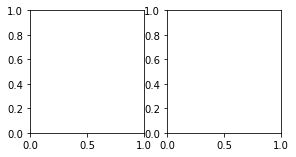

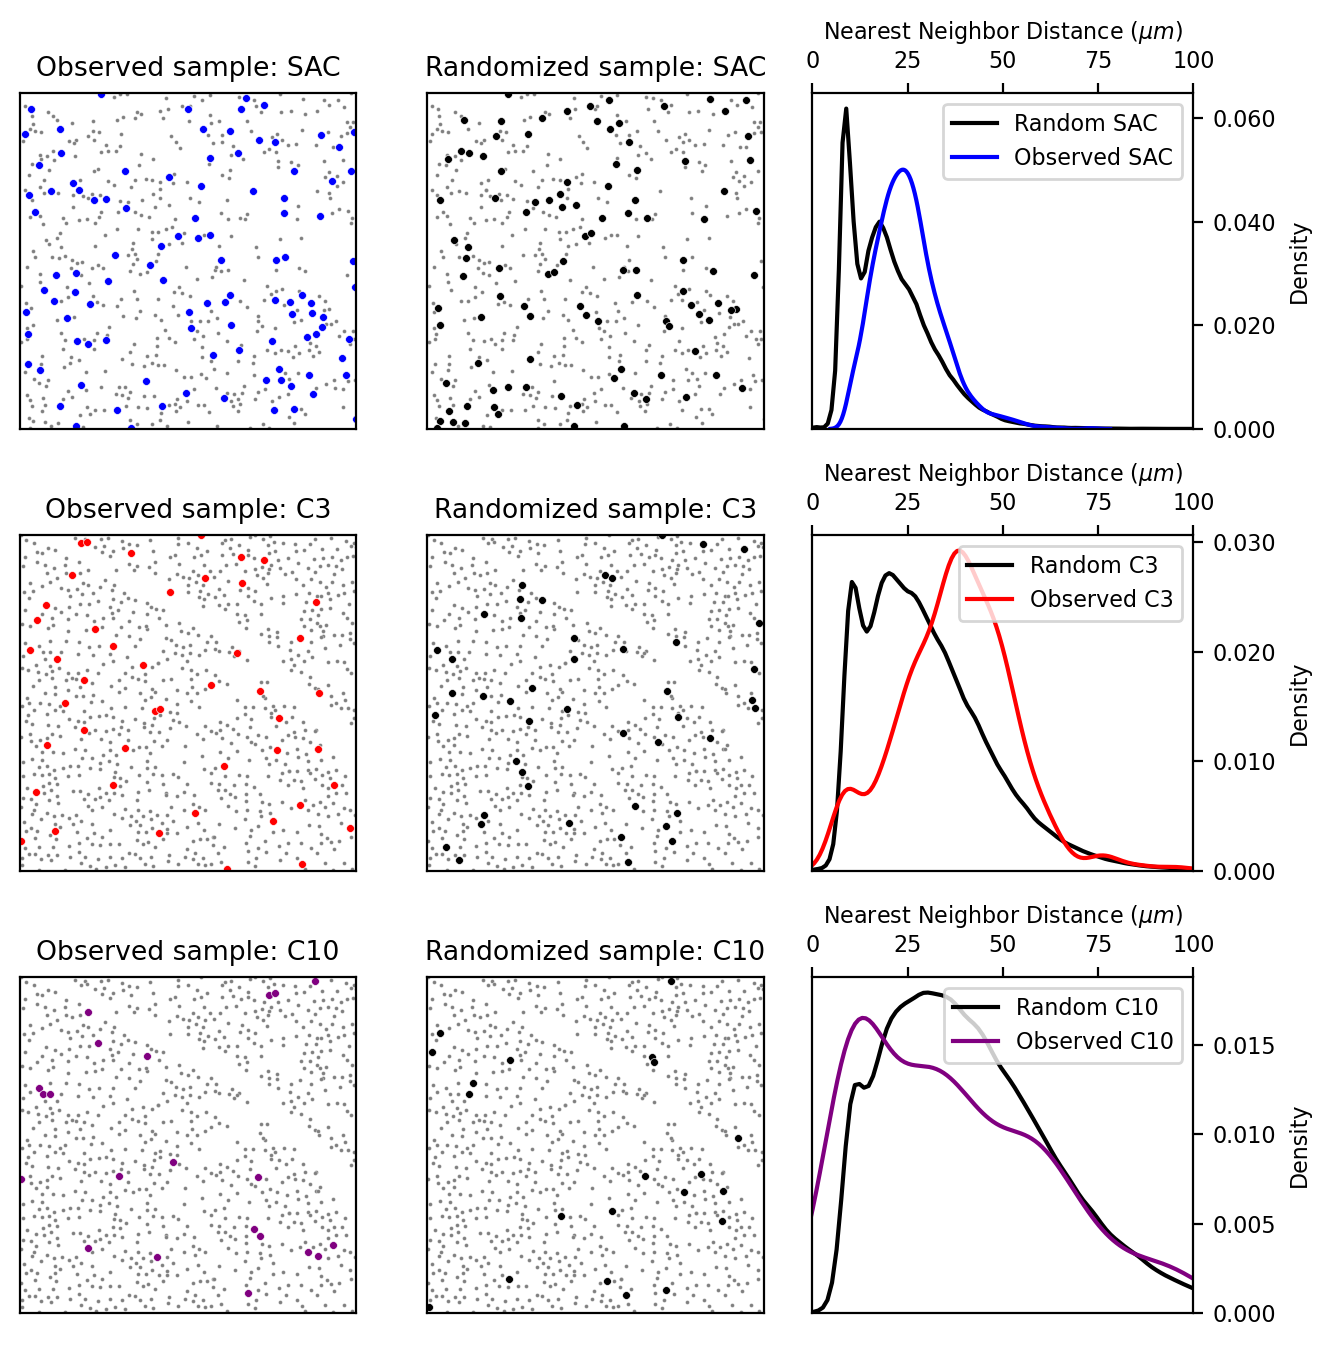

In [23]:
run = 3
w = h =  2.25
random_color='black'
figure_dir = os.path.join(constants.BASE_DIR,"figures","Figure_4")
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(w*2,h))
ctypes=['SAC','C3','C10']
colors=['Blue','Red','Purple']
with plt.rc_context({'figure.dpi':200,'font.size':8,'font.sans-serif':'Arial'}):
    fig,ax= plt.subplots(ncols=3,nrows=len(ctypes),figsize=(w*3,h*len(ctypes)))
    for i,(ctype,color) in enumerate(zip(ctypes,colors)):
        ax_r = ax[i]
        
        _,vor = plot_voronoi(adata[~adata.obs['dup']],ctype=ctype,color=color,run=run,sample_poly=sg.Polygon(good_ROI[run][0][1]),ax=ax_r[0],shrink=0,s=8)
        _,vor = plot_voronoi(adata[~adata.obs['dup']],ctype=ctype,run=run,random_color=random_color,sample_poly=sg.Polygon(good_ROI[run][0][1]),shrink=0,ax=ax_r[1],randomized=True,s=8)


        palette = {ctype:color,'Null':random_color}
        plot_density(df_distances,ctype=ctype,ax=ax_r[2],palette=palette)
        ax_r[2].xaxis.tick_top()
        ax_r[2].xaxis.set_label_position('top')
        ax_r[2].yaxis.tick_right()
        ax_r[2].yaxis.set_label_position('right')
        ax_r[2].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
        ax_r[2].legend(loc='upper right')

    
    fig.tight_layout()
    fig.savefig(os.path.join(figure_dir,"{}_joint_plot_dist{}.pdf".format(ctypes,suffix)))
    fig.show()

In [7]:
from statannotations.Annotator import Annotator
def quant_mosaic(df_RI,types,type_col='Type',cat_col='Category',score_col='NNRI',color='cornflowerblue',p_height=-1,p_fontsize=10,s=3,test='Mann-Whitney',pairs=None,correction='BH',figsize=(9,3),ylim=(0,4),output_f=""):
    statistics = []
    if pairs is None:
        pairs = []
        for rt in types:
            subgroups = []
            for cat in df_RI[cat_col].unique():
                subgroups.append((rt,cat))
            pairs.append(subgroups)
        
        pairs=  tuple(pairs)
    print(pairs)

    with plt.rc_context({"figure.figsize":figsize,"figure.dpi":200,'font.size':8,'font.sans-serif':'Arial'}):
        df = df_RI[df_RI[type_col].isin(types)]
        plot_data = {
            'data':df,
            'x':'Type',
            'hue':'Category',
            'y':score_col,
            'palette':{'Null':'Grey','Observed':color},
            'err_kws':{'linewidth':0.5,'color':'black'},
            'capsize':0.5,
            'edgecolor':'black',
            'order':types
        
        }
        print(pairs)
        ax = sns.barplot(**plot_data)

    with plt.rc_context({"figure.figsize":figsize,'figure.dpi':200,'font.size':8,'font.sans-serif':'Arial'}):
        annotator = Annotator(ax, pairs,plot='barplot',**plot_data)
        annotator.configure(test=test, verbose=False,line_width=0.5,comparisons_correction=correction)
        _, results = annotator.apply_and_annotate()
        plt.xlabel('')
        plt.xticks(rotation=90)
        plt.xlim(-0.75,len(types)-0.25)
        plt.ylim(ylim)
        plt.savefig(output_f,bbox_inches='tight')
        plt.show()
        
    #return dict(zip(order,statistics))

([('SAC', 'Null'), ('SAC', 'Observed')], [('C1', 'Null'), ('C1', 'Observed')], [('C2', 'Null'), ('C2', 'Observed')], [('C3', 'Null'), ('C3', 'Observed')], [('C4', 'Null'), ('C4', 'Observed')], [('C5', 'Null'), ('C5', 'Observed')], [('C6', 'Null'), ('C6', 'Observed')], [('C7', 'Null'), ('C7', 'Observed')], [('C8', 'Null'), ('C8', 'Observed')], [('C9', 'Null'), ('C9', 'Observed')], [('C10', 'Null'), ('C10', 'Observed')], [('C11', 'Null'), ('C11', 'Observed')], [('C12', 'Null'), ('C12', 'Observed')], [('C13', 'Null'), ('C13', 'Observed')], [('C14', 'Null'), ('C14', 'Observed')], [('C15', 'Null'), ('C15', 'Observed')], [('C17', 'Null'), ('C17', 'Observed')], [('C18', 'Null'), ('C18', 'Observed')], [('C19', 'Null'), ('C19', 'Observed')], [('C20', 'Null'), ('C20', 'Observed')], [('C21', 'Null'), ('C21', 'Observed')], [('C23', 'Null'), ('C23', 'Observed')], [('C24', 'Null'), ('C24', 'Observed')], [('C25', 'Null'), ('C25', 'Observed')], [('C26', 'Null'), ('C26', 'Observed')], [('C29', 'Null'),

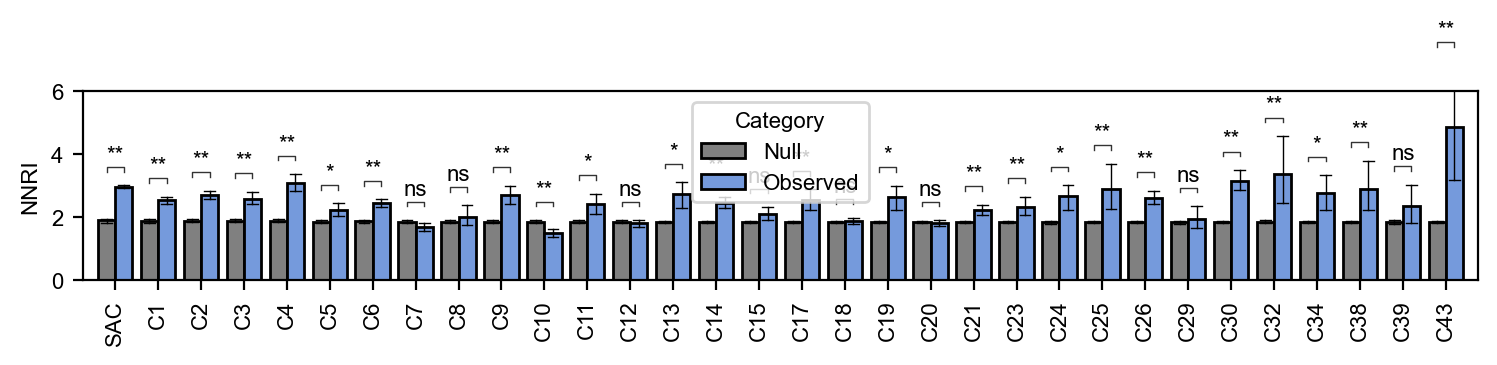

In [11]:
%matplotlib inline
t_counts = adata.obs['final_assignment'].value_counts()
valid_types = t_counts[t_counts > 1900].index


order = ['SAC'] + [t for t in df_NNRI['Type'].unique()[2:] if t in valid_types]
quant_mosaic(df_NNRI,order,type_col='Type',figsize=(9,1.25),test='Wilcoxon',ylim=(0,6),output_f=os.path.join(figure_dir,f"NNRI_restricted{suffix}.pdf"))

([('SAC', 'Null'), ('SAC', 'Observed')], [('C1', 'Null'), ('C1', 'Observed')], [('C2', 'Null'), ('C2', 'Observed')], [('C3', 'Null'), ('C3', 'Observed')], [('C4', 'Null'), ('C4', 'Observed')], [('C5', 'Null'), ('C5', 'Observed')], [('C6', 'Null'), ('C6', 'Observed')], [('C7', 'Null'), ('C7', 'Observed')], [('C8', 'Null'), ('C8', 'Observed')], [('C9', 'Null'), ('C9', 'Observed')], [('C10', 'Null'), ('C10', 'Observed')], [('C11', 'Null'), ('C11', 'Observed')], [('C12', 'Null'), ('C12', 'Observed')], [('C13', 'Null'), ('C13', 'Observed')], [('C14', 'Null'), ('C14', 'Observed')], [('C15', 'Null'), ('C15', 'Observed')], [('C17', 'Null'), ('C17', 'Observed')], [('C18', 'Null'), ('C18', 'Observed')], [('C19', 'Null'), ('C19', 'Observed')], [('C20', 'Null'), ('C20', 'Observed')], [('C21', 'Null'), ('C21', 'Observed')], [('C23', 'Null'), ('C23', 'Observed')], [('C24', 'Null'), ('C24', 'Observed')], [('C25', 'Null'), ('C25', 'Observed')], [('C26', 'Null'), ('C26', 'Observed')], [('C29', 'Null'),

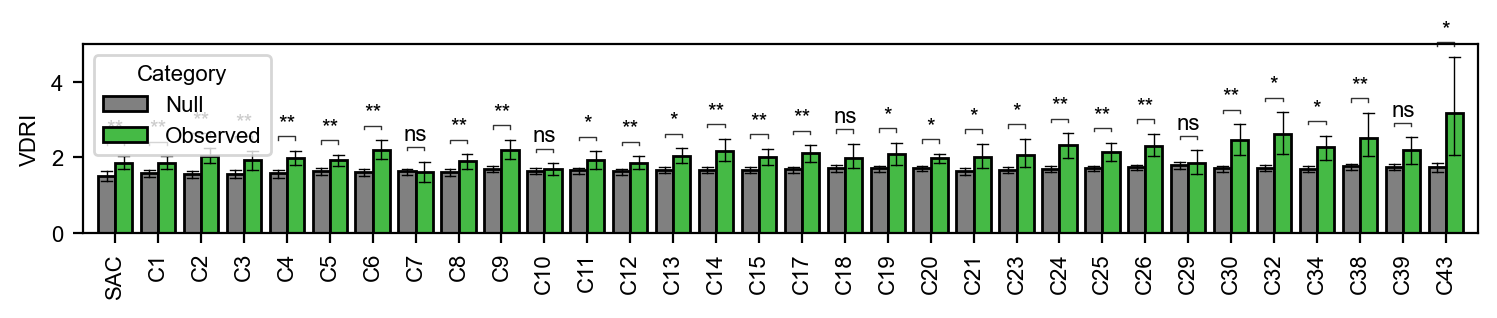

In [16]:
%matplotlib inline
t_counts = adata.obs['final_assignment'].value_counts()
valid_types = t_counts[t_counts > 1900].index

order = ['SAC'] + [t for t in df_VDRI['Type'].unique()[2:] if t in valid_types]
quant_mosaic(df_VDRI,order,score_col='VDRI',type_col='Type',color='limegreen',figsize=(9,1.25),ylim=(0,5),test='Wilcoxon',output_f=os.path.join(figure_dir,f"VDRI_restricted{suffix}.pdf"))

([('C1', 'Null'), ('C1', 'Observed')], [('C2', 'Null'), ('C2', 'Observed')], [('C3', 'Null'), ('C3', 'Observed')], [('C4', 'Null'), ('C4', 'Observed')], [('C16_V', 'Null'), ('C16_V', 'Observed')], [('C16_D', 'Null'), ('C16_D', 'Observed')], [('C1-C2', 'Null'), ('C1-C2', 'Observed')], [('C3-C4', 'Null'), ('C3-C4', 'Observed')], [('C16', 'Null'), ('C16', 'Observed')])
([('C1', 'Null'), ('C1', 'Observed')], [('C2', 'Null'), ('C2', 'Observed')], [('C3', 'Null'), ('C3', 'Observed')], [('C4', 'Null'), ('C4', 'Observed')], [('C16_V', 'Null'), ('C16_V', 'Observed')], [('C16_D', 'Null'), ('C16_D', 'Observed')], [('C1-C2', 'Null'), ('C1-C2', 'Observed')], [('C3-C4', 'Null'), ('C3-C4', 'Observed')], [('C16', 'Null'), ('C16', 'Observed')])


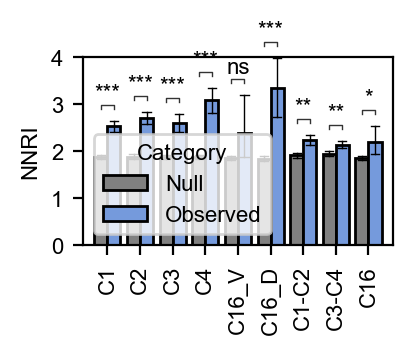

In [121]:
%matplotlib inline
order = ['C1','C2','C3','C4','C16_V','C16_D','C1-C2','C3-C4','C16']
df_t = df_j[df_j['Type'].isin(order)]
quant_mosaic(df_t,order,figsize=(2,1.25),output_f=os.path.join(figure_dir,f"Mixtures_NNRI{suffix}.pdf"))

([('C1', 'Observed'), ('C1-C2', 'Observed')], [('C2', 'Observed'), ('C1-C2', 'Observed')], [('C3', 'Observed'), ('C3-C4', 'Observed')], [('C4', 'Observed'), ('C3-C4', 'Observed')], [('C16_V', 'Observed'), ('C16', 'Observed')], [('C16_D', 'Observed'), ('C16', 'Observed')])
([('C1', 'Observed'), ('C1-C2', 'Observed')], [('C2', 'Observed'), ('C1-C2', 'Observed')], [('C3', 'Observed'), ('C3-C4', 'Observed')], [('C4', 'Observed'), ('C3-C4', 'Observed')], [('C16_V', 'Observed'), ('C16', 'Observed')], [('C16_D', 'Observed'), ('C16', 'Observed')])


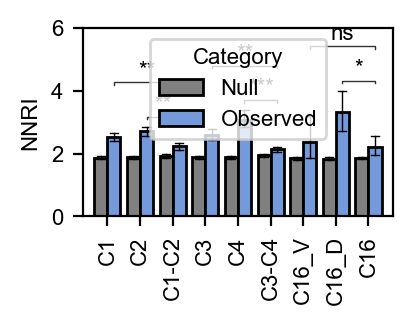

In [24]:
%matplotlib inline
order = ['C1','C2','C1-C2','C3','C4','C3-C4','C16_V','C16_D','C16']
df_t = df_j[df_j['Type'].isin(order)]

pairs = (
    [('C1','Observed'),('C1-C2','Observed')],
    [('C2','Observed'),('C1-C2','Observed')],
    [('C3','Observed'),('C3-C4','Observed')],
    [('C4','Observed'),('C3-C4','Observed')],
    [('C16_V','Observed'),('C16','Observed')],
    [('C16_D','Observed'),('C16','Observed')]
)
quant_mosaic(df_t,order,figsize=(2,1.25),pairs=pairs,ylim=(0,6),output_f=os.path.join(figure_dir,f"Mixtures_NNRI_rearr{suffix}.pdf"))